In [ ]:
#read write xslx file
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
#model = torch.load('/content/phobert_fold5.pth')

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

In [ ]:
df=pd.read_csv('/content/dev.csv')

In [ ]:
df.drop(columns=['Rating'], inplace=True)

In [ ]:
df

,Comment,Label,SpamLabel
0,"nhỏ gọn. tiện lợi , chất lượng hơn mong đợi nữ...",0,0
1,"sản phẩm siu mềm và đẹp, canh sale nên mua với...",0,0
2,"Mua được giá rẻ, giao hàng nhanh.",1,2
3,Chất lượng sản phẩm tuyệt vời 🤩 đóng gói sản p...,1,1
4,mình rất thít tiki cái gì cũng mua ở tiki hết ...,0,0
...,...,...,...
1585,Loại túi to nhưng vẫn bé hơn mình nghĩ. Bé 16t...,0,0
1586,"Món nầy thì bé mèo nhà mình vẫn chịu ăn đều, n...",0,0
1587,"tiki now vẫn cứ là ok, nvgh lúc 9 rưỡi sáng ( ...",0,0
1588,Mèo nhà mình rất thích ăn hạt này. :))),0,0


In [ ]:
train_df , valid_df , test_df  = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Label)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
train_df.info(), test_df.info()

<AxesSubplot:xlabel='Label', ylabel='count'>

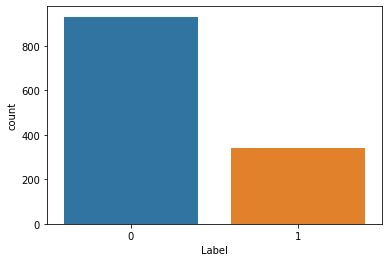

In [ ]:
sns.countplot(x='Label', data=train_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text==0:
            return 0
        elif text==1:
            return 1

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Label'])

        return text, label

Text(0.5, 6.79999999999999, 'Token Count')

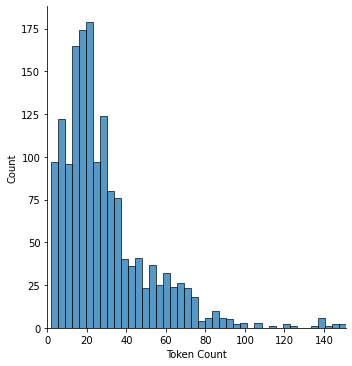

In [ ]:
# Distribution of length of Sentence
all_data = train_df.Comment.tolist() + test_df.Comment.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model, f'phobert_fold{fold+1}.pth')           
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------


In [ ]:
model

SentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

In [ ]:
torch.save(model, 'phobert_pre.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
 torch.save(model.state_dict(), f'phobert_fold.h5')

In [ ]:
newmodel.load_state_dict(torch.load('/content/phobert_fold4.pth'))

NameError: ignored

In [ ]:
newmodel = torch.load('/content/phobert_pre.pth')
#model.eval()

AttributeError: ignored

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras 
    "/content/phobert_fold.h5" "/content"

IndentationError: ignored

In [ ]:
!pip install tensorflowjs


In [ ]:
!tensorflowjs_converter --input_format keras 
    ‘/content/phobert_fold.h5’ ‘/content/mnist-model’

IndentationError: ignored

In [ ]:
!sudo pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras \
                       /content/phobert_fold4.pth \
                       /content

2023-03-11 06:36:21.414703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-11 06:36:21.414802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-11 06:36:21.414822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.9/dist-p

In [ ]:

!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model model tfjs_model

2023-03-11 06:39:37.600504: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-11 06:39:37.600613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-11 06:39:37.600632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.9/dist-p

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=2)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

RuntimeError: ignored

In [ ]:
class_names = ['ham','spam']

In [ ]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = newmodel(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
    print(f'Sentiment: {y_pred}')

In [ ]:
infer('	dep gia re', tokenizer)

Text: 	dep gia re
Sentiment: ham
Sentiment: tensor([0], device='cuda:0')


In [ ]:
model.summary()

AttributeError: ignored

In [ ]:
from google.colab import files
files.download('/content/phobert_fold5.pth') 

FileNotFoundError: ignored